In [1]:
#Use this line to set the number of  CPU used for execution of the program (if it's not working, use the commented line:
#see https://stackoverflow.com/questions/17053671/python-how-do-you-stop-numpy-from-multithreading/21673595 for more information)

import os

#os.environ['OPENBLAS_NUM_THREADS'] = '3' 
os.environ['MKL_NUM_THREADS'] = '3'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Low rank VAR(1) Simulation

The main goal of this notebook is to implement and to test the low_rank VAR(1) algorithm. In order to do so, we will:
- generate data according to a low-rank high dimensionnal VAR(1) process
- implement the estimation of the low rank VAR(1) models
- compare this model with a standard VAR(1) among differents  features


We want to simulate an VAR(1) processus generated by a matrix A of rank r. We consider the time series $(X_t) \in \mathbb{R}^M$ of length generated by 

$$ X_{t+1} = A X_t + \epsilon_t   $$
    
where $\epsilon_t \sim \mathcal{N}(0,\sigma^{2})\$ 


## Generation


In order to generate A, we use the following procedure:

- We uniformly generate U and V matrices of respective shape $M\times r$ and $r \times M$. Their columns are on the unit sphere.
- We generate $\lambda_1,\dots\lambda_r$ r singular values according to a $\mathcal{\beta}(a,1)$ distribution
- We take $A = U diag(\lambda_1, \dots, \lambda_r) V^T$

In [3]:
def random_unit_matrix(M,P):
    list_col = [ np.random.uniform(low = - 1, size =  (M,1)) for i in range(P)]
    list_col = [ col/np.linalg.norm(col) for col in list_col]
    return np.concatenate(list_col , axis = 1)

def random_inversible_matric(M,P):
    pass

def generate_matrix(M, r, a) : 
    U = random_unit_matrix(M,r)
    V = random_unit_matrix(r,M)
    diag = np.diag(np.random.beta(a,1, size =r))
    return U.dot(diag.dot(V))

def tronc_gaussian(sigma, limit = 1):
    """Truncated centred gaussian distribution with deviation sigma"""
    ret = np.random.normal(scale = sigma)
    if abs(ret) > limit:
        return tronc_gaussian(sigma, limit=limit)
    return ret

def vect_tronc_gaussian(n,m, sigma = 1, limit = 1):
    A = np.array([tronc_gaussian(sigma, limit=limit) for i in range(n*m)])
    return A.reshape((n,m))

def generate_series(A,n,sigma= 1, limit_gaussian = 1 ):
    M = A.shape[0]
    cur =  vect_tronc_gaussian(M,1,sigma= sigma, limit=limit_gaussian)
    list_vect = [cur]
    for i in range(n-1):
        cur = A.dot(cur) + vect_tronc_gaussian(M,1,sigma=sigma, limit=limit_gaussian)
        list_vect.append(cur)
    return np.concatenate(list_vect, axis = 1)
    


In [4]:
A = generate_matrix(100,10,1)
series = generate_series(A,1000)

## 3 Different estimators

### Benchmark : Full Rank Estimator

To compare the performance of our model, we use the standard VAR(1) estimator $\widehat{A}_{std}$ defined as :

$$ \widehat{A}_{std}  =\underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})}{argmin} \sum_{i=0}^n \|X_{i+1} - A X_i \|_2^2 $$ 

If we set :

$$ Y = \left(X_1| X_2 | \dots | X_n \right)$$
$$ X = \left(X_0|X_1 | \dots | X_{n-1} \right)$$

We have then 

$$  \widehat{A}_{std} = \underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})}{argmin} \|Y- AX \|_F^2 $$

where $\|\|_F$ is the Frobenius norm. Therefore, we can have an exact expression for $\widehat{A}_{std}$:
$$\widehat{A}_{std} = (X X^T)^{-1} X^T Y$$


In [5]:
def empirical_risk(estim,series ):
    n = series.shape[1]-1 
    return( 1/n * sum([np.linalg.norm(series[:,i+1] - estim @ series[:,i])**2  for i in range(n)]) ) 

def std_estimator(series):
    Y = series[:,1:]
    X = series[:,:-1]
    return  (Y @ X.transpose()) @  np.linalg.inv(X@ X.transpose() ) 

### Low Rank Estimator

In this setting, we perform the minimization describe in the paper 

$$ \widehat{U}_{low rank}, \widehat{V}_{low rank}  =\underset{U,V \in \mathcal{M}_{M \times r }(\mathbb{R})}{argmin} \sum_{i=0}^n \|X_{i+1} - U V^T X_i \|_2^2 $$ 

And we have then $\widehat{A}_{low rank} = \widehat{U}_{low rank} \widehat{V}_{low rank} $

To perform this minimization, we alternate minimisation on $U$ then $V$. There are also exact expression for this form. When we suppose that we know the underlying rank of the simulation, this estimator is called an 'oracle' estimator.

In [6]:
def min_U(V,X,Y):
    VX =  V @ X
    return (Y @ VX.transpose()) @  np.linalg.inv(VX@ VX.transpose() ) 
    
def min_V(U,X,Y):
    tUYtX = U.transpose() @ Y @ X.transpose()
    return np.linalg.inv(U.transpose()@ U ) @ tUYtX  @  np.linalg.inv(X@ X.transpose() ) 

def low_rank_estimator(series, r = 10 ,  n_iter = 10, verbose = False ):
    """EStimateur approché"""
    Y = series[:,1:]
    X = series[:,:-1]
    V_cur = random_unit_matrix(r, series.shape[0])
    for i in range(n_iter):
        try :
            U_cur = min_U(V_cur, X, Y)
            V_cur = min_V(U_cur, X, Y)
            if verbose:
                print(empirical_risk(U_cur @ V_cur, series))
        except:
            return('Fail')
    return U_cur @ V_cur

def low_rank_bis(series, r= 10):
    tot_estim = std_estimator(series)
    U,D,V = np.linalg.svd(tot_estim)
    D[r:] = 0
    return U @ np.diag(D) @ V

def low_rank_ter(series, r= 10):
    Y = series[:,1:]
    X = series[:,:-1]
    U,D,V = np.linalg.svd(Y,full_matrices=False)
    D[r:] = 0
    Yhat = U @ np.diag(D) @ V
    return (Yhat @ X.transpose()) @  np.linalg.inv(X@ X.transpose() ) 

Ahatbis= low_rank_bis(series)
Ahat = low_rank_estimator(series)
Ahatter = low_rank_ter(series)

### Penalized Full Rank Estimator

Another way to compare is to penalize the rank:

$$  \widehat{A}_{pen} = \underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})}{argmin} \|Y- AX \|_F^2  + C \sqrt{rg(A)}$$

This minimization is hard to compute in practice, beause we don't have an explicit formula for the low rank minimization. Furthermore it is impossible to use gradient-descent-like algorithm in this case because of the discontinuities.

So we have to start from an approximation of thelow rank problem:

$$\widehat{A_{lr}}(r) = \underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})\\ rg(A) = r }{argmin} \|Y- AX \|_F^2 $$ 

Again, we don't have an explicit formula for $\widehat{A_{lr}}(r)$, but we can use the previous procedure to approach it. As it is computationnaly expensive, we use $P_r(\widehat{A}_{std})$ projection of $\widehat{A}_{std}$ on the set of matrices of rank $r$ as a estimator of $\widehat{A_{lr}}(r) $.

We are then trying to compute

$$ \widehat{r_{pen}} = \underset{r \in [0,M] }{argmin} \|Y- P_r(\widehat{A}_{std}) X \|_F^2  + C \sqrt{r}$$


In [7]:
from math import sqrt

def penalized_est(series, C = 1, return_rank = False):
    M = series.shape[0]
    err = np.zeros(M-1)
    list_mod = list()
    tot_estim = std_estimator(series)
    try : 
        U,D,V = np.linalg.svd(tot_estim)
        for r in range(M-1):
            Dcopy = D.copy()
            Dcopy[(r+1):] = 0
            Ar =  U @ np.diag(Dcopy) @ V
            err[r] = empirical_risk(Ar,series) + C* sqrt(r+1)
            list_mod.append(Ar)
    except:
        return 'Fail'
    
    if return_rank:
        return list_mod[np.argmin(err)], (np.argmin(err)+1)
    return list_mod[np.argmin(err)]

## Slope Heuristics

We introduce the slope heuristics proposed by Birgé and Massart[1] to compute a good value for C. The idea is to compute the complexity of the best model $\widehat{A_C}$ for each value of C.

There is normaly a value $\widehat{C}$ of C such that the complexity (here the rank of $\widehat{A_C}$) is large if  $C < \widehat{C}$ and reasonnable otherwise. The slope heuristics proposed to choose $\tilde{C} = 2 * \widehat{C} $ as the ideal value for the parameters $C$

In [8]:
C_list = [0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50]
r_obt  = list()
for C in C_list:
    Apen, r = penalized_est(series,C=C, return_rank = True)
    r_obt.append(r)
    

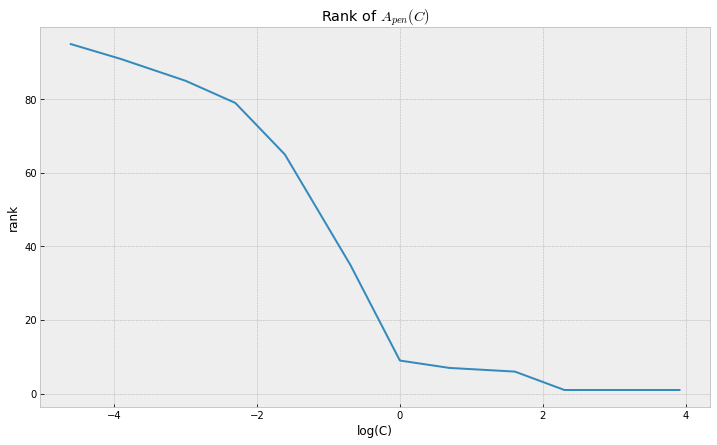

In [10]:
from math import log
plt.style.use('bmh')
plt.figure(figsize=(12,7))
plt.plot(list(map(log, C_list)),r_obt)
plt.xlabel('log(C)')
plt.ylabel('rank')
plt.title("Rank of $A_{pen}(C)$")
plt.show()

We effectively observe this phenomenon. Here we should choose $C=2$. The corresponding rank may be smaller than the underlying rank . 


In order to find the point where the slope change, we compute the penalized estimator $\widehat{A_{C_i}}$ for each coefficient $(C_i)_{i \in [0,p]}$ . Then we compute the rank $r_{(C_i)}$ of each of these predictor.

Then we choose:

$$\widehat{j} =  \underset{i \in [1,p-1]}{\text{argmax}} (r_{C_{i+1}} - r_{C_{i}}) - (r_{C_{i}} - r_{C_{i-1}}) $$

and we have $\widehat{C} = C_{\widehat{j}}$

In [12]:
def ideal_C(C_list, series):
    """Find the ideal penalisation coefficient for the penalized estimator"""
    r_obt  = list()
    for C in C_list:
        est = 'Fail'
        while est == 'Fail':
            est = penalized_est(series,C=C, return_rank = True)
        Apen, r = est
        if r == 1:
            #Case where the ideal rank is 1
            return 1
        r_obt.append(r)
    ser = pd.Series(r_obt)
    j = np.argmax(ser.diff(1).diff(1).fillna(float('-inf')).values) - 1
    return 2 * C_list[j]

In [12]:
ideal_C(C_list,series)

1

## Experience

In [9]:
def experience(M ,n,r,a , nb_iterations = 1000, nb_test= 100,C_list = [0.02,0.05,0.1,0.2,0.5,1,2,5,10,20]):
    list_res = list()
    
    #Slope heuristics
    A = generate_matrix(M,r,a)
    series = generate_series(A, n)
    C = ideal_C(C_list, series)
    
    for iteration in range(nb_iterations):
        A = generate_matrix(M,r,a)
        series = generate_series(A, n + nb_test)
        
        train_set, test_set = series[:,:-nb_test], series[:,-nb_test:]
        
        A_std =  std_estimator(train_set)
        A_low_rank = low_rank_estimator(train_set,r=r, n_iter = 5 )      
        if A_low_rank != 'Fail':
            A_pen = penalized_est(train_set, C=C)
            if A_pen != 'Fail':
                min_risk =  empirical_risk(A, test_set)
                err_1 = empirical_risk(A_std, test_set) - min_risk
                err_2 = empirical_risk(A_low_rank, test_set) - min_risk
                err_3 = empirical_risk(A_pen, test_set) - min_risk
                list_res.append([err_1,err_2, err_3])
    return np.array(list_res)

### Rank Importance

We fix the number n of observation, and we observe the risk excess for every estimator . We estimate the risk excess using 100 fresh values generated with A. There are some troubles with the matrix inversion, so there are some outliers. I suppose that this problem is caused by numerical problems while inversing quasi-non invertible matrics. I do not consider this matrices

In [10]:
#parameters

nb_iterations = 10 #Number of simulations for each point
M = 100
n = 1000

#We test the following rank
ranks = [1,2,3,5,10,15,25,50,75,100]

In [13]:
list_alpha = [1,0.5,0.1,0.05]
list_rep = list()
for alpha in list_alpha:
    list_inter = list()
    for rank in ranks:
        list_inter.append(experience(M, n, rank,alpha,nb_iterations=nb_iterations))
    list_rep.append(list_inter)

/home/garnier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/garnier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


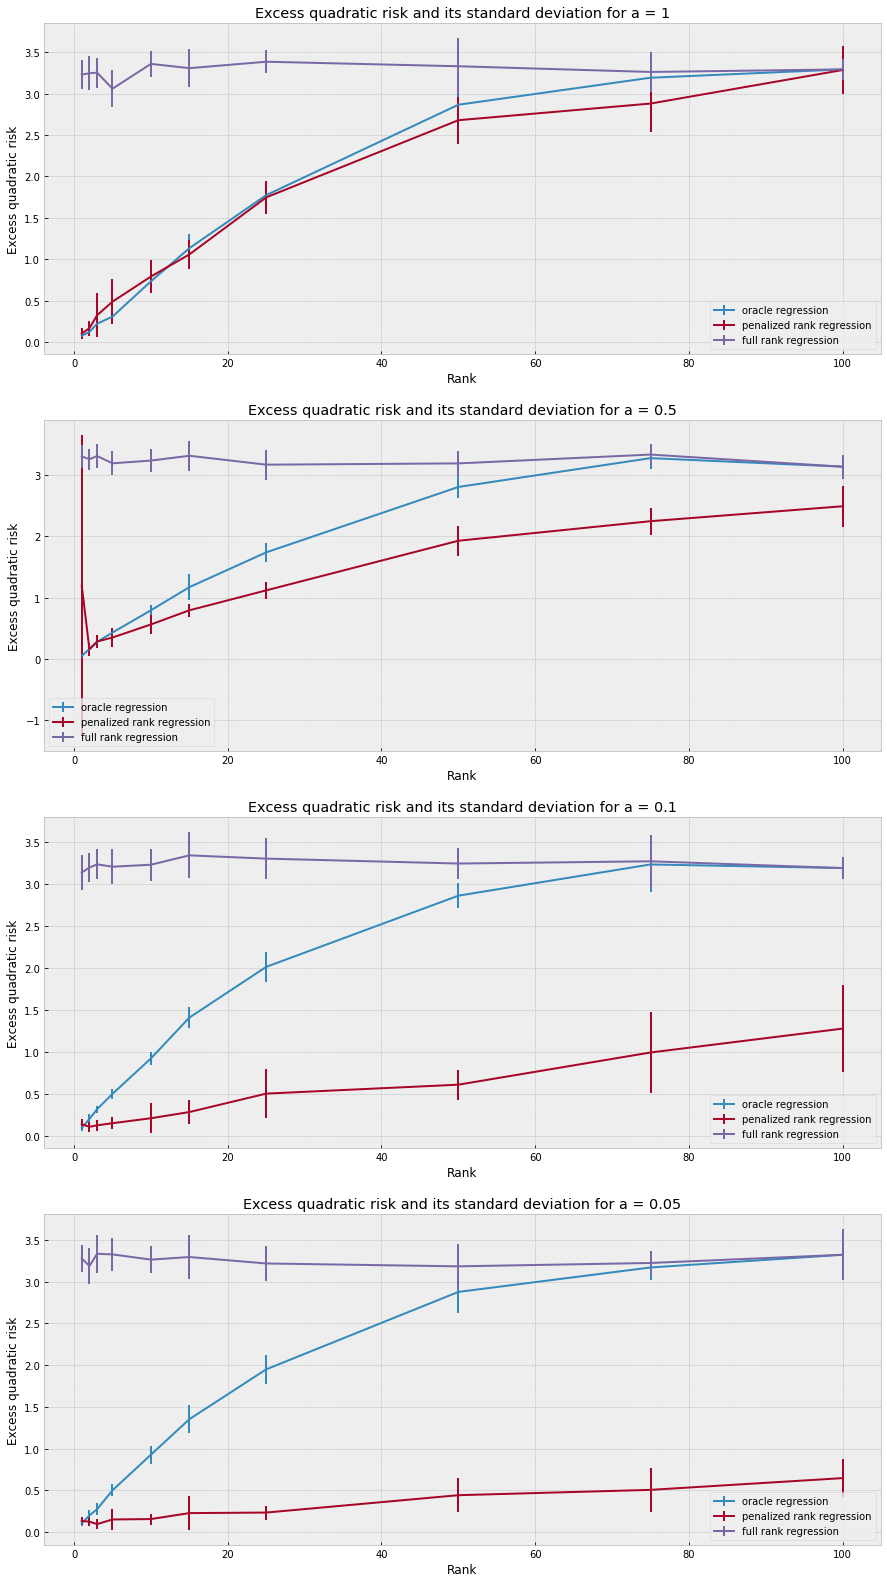

In [24]:
nb_alpha = len(list_alpha)
plt.style.use('bmh')

fig, axs = plt.subplots(nrows=nb_alpha, ncols=1, figsize=(15,7 * nb_alpha))

title =list_alpha
for i, liste in enumerate(list_rep):
    list_mean = list()
    list_std = list()
    for mat in liste:
        df = pd.DataFrame(mat)
        
        #removing outliers
        df =  df[df.iloc[:,0]<10]
        df =  df[df.iloc[:,2]<10]
        df =  df[df.iloc[:,1]<10]
        df = df[df.notna()]
        list_mean.append(df.mean(axis = 0))
        list_std.append(df.std(axis = 0))
    means = pd.concat(list_mean, axis=1)
    stds = pd.concat(list_std, axis=1)
    ax = axs[i]
    
    ax.errorbar( ranks,means.iloc[1,:], label = 'oracle regression', yerr= stds.iloc[1,:])
    ax.errorbar( ranks,means.iloc[2,:], label = 'penalized rank regression', yerr= stds.iloc[2,:])
    ax.errorbar( ranks,means.iloc[0,:], label = 'full rank regression', yerr= stds.iloc[0,:])
    ax.set_title('Excess quadratic risk and its standard deviation for a = ' +str(title[i]))
    ax.set_xlabel('Rank')
    ax.set_ylabel('Excess quadratic risk')
    ax.legend()

plt.show()


In [29]:
table_result = pd.DataFrame(means.values, index= ['full_rank','oracle', 'penalized'], columns=ranks)

,1,2,3,5,10,15,25,50,75,100
full_rank,3.280079,3.189679,3.336147,3.329261,3.266144,3.297527,3.220236,3.185812,3.226044,3.324601
oracle,0.101644,0.197019,0.271901,0.498857,0.925854,1.351788,1.949995,2.878993,3.172090,3.324601
penalized,0.131251,0.122526,0.093522,0.148800,0.153799,0.225280,0.231755,0.440223,0.504098,0.645101


We observe that the perfomance of the full rank regression doesn't seem to be affected by the rank of the underlying matrices. Low rank regression perfoms faster than the other regression and better when the underlying rank of matrix are small.

### Importance of the sample numbers

We now fix the rank of the underlying matrix r= 10 and M = 100 and try to study the impact of the number of observations n

In [79]:
from math import log10

#parameters

nb_iterations = 100
M = 100
r = 10

#We test the following sample numbers
sample_numbers = [200,300, 500, 1000,2000,3000,5000, 10000]
log_sample = list(map(log10, sample_numbers))

In [80]:
list_alpha = [1,0.5,0.1,0.01]
list_repn = list()
for alpha in list_alpha:
    list_intern = list()
    for n in sample_numbers:
        list_intern.append(experience(M, n, r,alpha,nb_iterations=nb_iterations))
    list_repn.append(list_intern)

/home/CDBDX/remy.garnier/.virtualenvs/pred_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/CDBDX/remy.garnier/.virtualenvs/pred_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


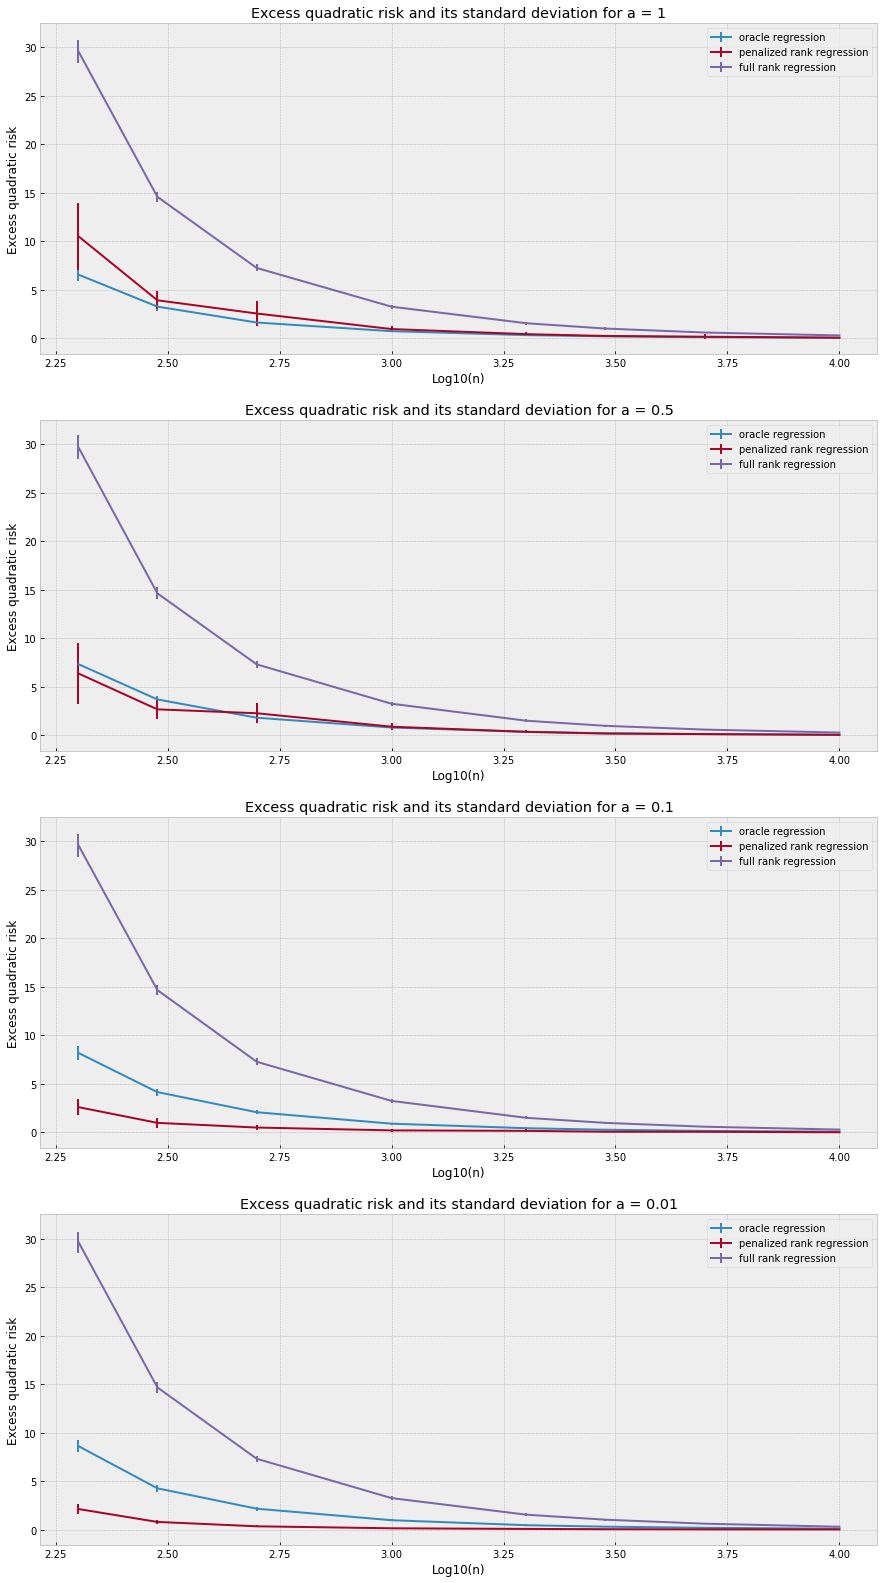

In [83]:
n_alpha = len(list_alpha)


fig, axs = plt.subplots(nrows=n_alpha, ncols=1, figsize=(15,7 * n_alpha), sharey=True)

title = list_alpha
for i, liste in enumerate(list_repn):
    list_mean = list()
    list_std = list()
    for mat in liste:
        df = pd.DataFrame(mat)
        df =  df[df.iloc[:,0]<100]
        df =  df[df.iloc[:,1]<100]
        df =  df[df.iloc[:,2]<100]
        df = df[df.notna()]
        list_mean.append(df.mean(axis = 0))
        list_std.append(df.std(axis = 0))
    means = pd.concat(list_mean, axis=1)
    stds = pd.concat(list_std, axis=1)
    ax = axs[i]

    ax.errorbar( log_sample ,means.iloc[1,:], label = 'oracle regression', yerr= stds.iloc[1,:])
    ax.errorbar( log_sample ,means.iloc[2,:], label = 'penalized rank regression', yerr= stds.iloc[2,:])
    ax.errorbar( log_sample ,means.iloc[0,:], label = 'full rank regression', yerr= stds.iloc[0,:])
    ax.set_title('Excess quadratic risk and its standard deviation for a = ' +str(title[i]))
    ax.set_xlabel('Log10(n)')
    ax.set_ylabel('Excess quadratic risk')
    ax.legend()

plt.show()


The low rank regression performs better with fewer information. In order to see the relative comportment of the full rank regression and the oracle, we show the ratio between the oracle and full rank excess risk on one hand, and the penalized regression and the full rank excess risk on the other hand 

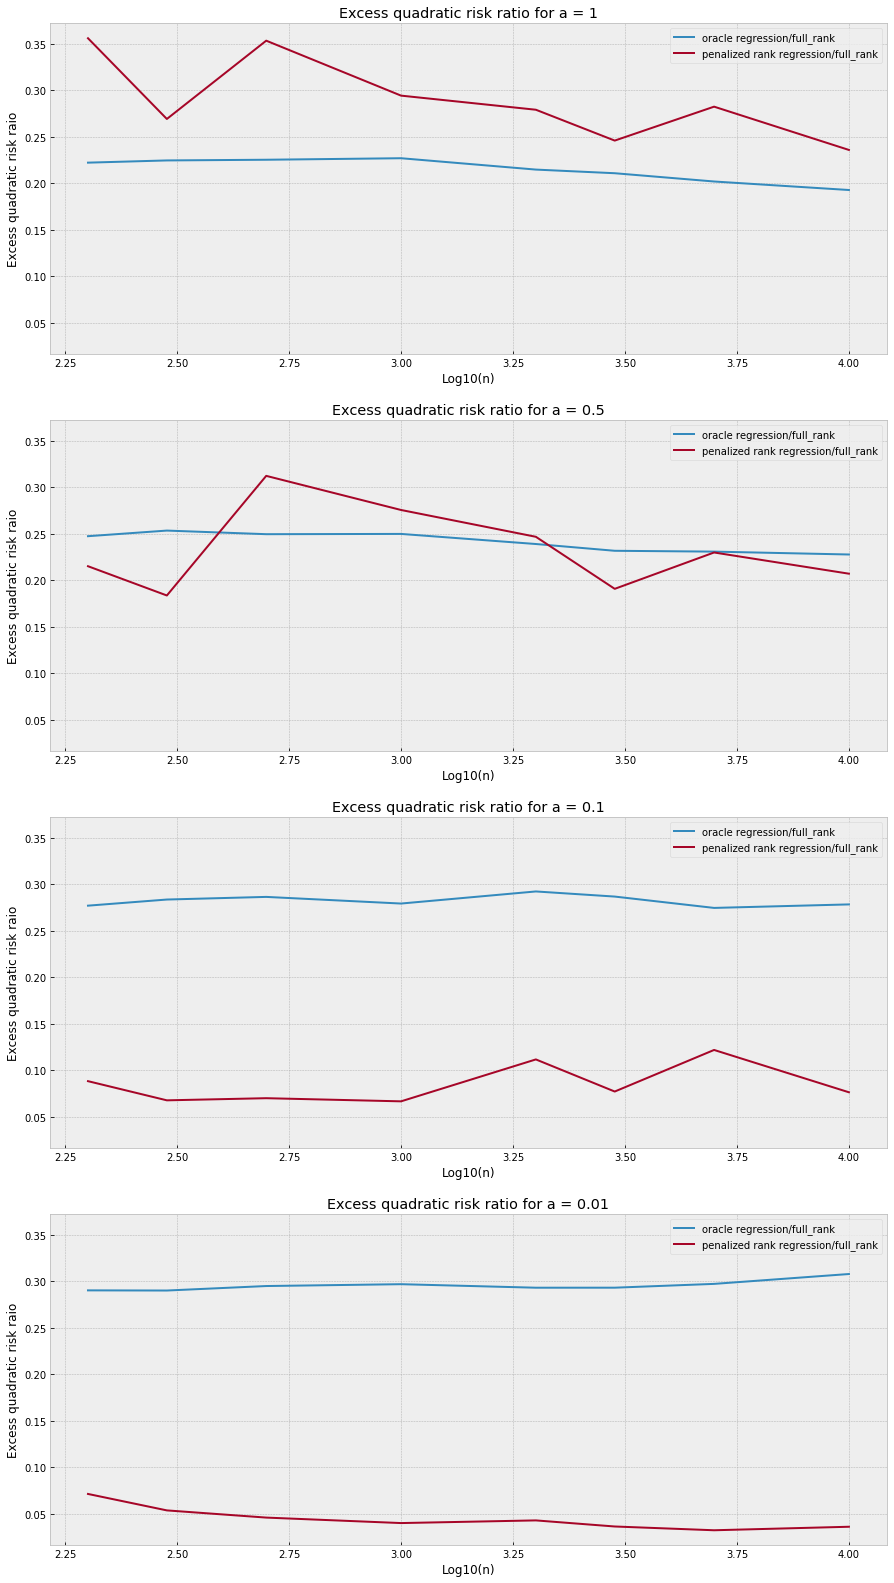

In [82]:
fig, axs = plt.subplots(nrows=n_alpha, ncols=1, figsize=(15,7 * n_alpha), sharey=True)

title = list_alpha
for i, liste in enumerate(list_repn):
    list_mean = list()
    list_std = list()
    for mat in liste:
        df = pd.DataFrame(mat)
        df =  df[df.iloc[:,0]<100]
        df =  df[df.iloc[:,1]<100]
        df =  df[df.iloc[:,2]<100]
        df = df[df.notna()]
        list_mean.append(df.mean(axis = 0))
        list_std.append(df.std(axis = 0))
    means = pd.concat(list_mean, axis=1)
    stds = pd.concat(list_std, axis=1)
    ax = axs[i]
    ax.plot( log_sample ,means.iloc[1,:]/means.iloc[0,:], label = 'oracle regression/full_rank')
    ax.plot( log_sample ,means.iloc[2,:]/means.iloc[0,:], label = 'penalized rank regression/full_rank')
    ax.set_title('Excess quadratic risk ratio for a = ' +str(title[i]))
    ax.set_xlabel('Log10(n)')
    ax.set_ylabel('Excess quadratic risk raio')
    ax.legend()

plt.show()


## References

[1] Birge, L. and Massart, P. (2006). Minimal penalties for gaussian model selection.
Probability Theory and Related Fields, 138(1-2):33{73.

..
